In [ ]:
#gh2617: Time Series AR(1) Regression Example
# Credit: Github Copilot in variable naming, plot creation, and code structuring/organization

import os, math, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.iolib.summary2 import summary_col

DATA_DIR = '.'  
PLOTS_DIR = os.path.join(DATA_DIR, "ts_outputs")



In [ ]:
# helper methods
def build_transitions(df_metric):
    prevs, curs, pats, ts = [], [], [], []
    for p, g in df_metric.groupby("patient"):
        g2 = g.sort_values("stage_index")
        for t in [1,2]:
            x_tm1 = g2.loc[g2["stage_index"]==t-1, "value"]
            x_t   = g2.loc[g2["stage_index"]==t,   "value"]
            if len(x_tm1)==1 and len(x_t)==1:
                prevs.append(float(x_tm1.iloc[0]))
                curs.append(float(x_t.iloc[0]))
                pats.append(p)
                ts.append(t)
    return pd.DataFrame({"patient": pats, "t": ts, "X_tm1": prevs, "X_t": curs})

def fit_ar1_pooled(df_metric):
    trans = build_transitions(df_metric)
    X = add_constant(trans["X_tm1"].values)
    y = trans["X_t"].values
    model = OLS(y, X).fit()
    return model, trans

def plot_transition(metric, res):
    trans = res["trans"]
    model = res["model"]
    xgrid = np.linspace(trans["X_tm1"].min()-0.1, trans["X_tm1"].max()+0.1, 200)
    ygrid = model.params[0] + model.params[1] * xgrid
    plt.figure(figsize=(6,5))
    plt.scatter(trans["X_tm1"], trans["X_t"])
    plt.plot(xgrid, ygrid, linewidth=2)
    plt.title(f"Synthetic — AR(1) Pooled Fit: {metric}\n X_t = c + φ X_{{t-1}} + ε")
    plt.xlabel("X_{t-1}")
    plt.ylabel("X_t")
    plt.tight_layout()
    plt.show()
    return outpath


In [ ]:
# Load ORCO files (portable)
tau_path  = os.path.join(DATA_DIR, "orco_tau.csv")
lv_path   = os.path.join(DATA_DIR, "orco_lv.csv")
rv_path   = os.path.join(DATA_DIR, "orco_rv.csv")
curv_path = os.path.join(DATA_DIR, "orco_curvature.csv")

tau_df  = pd.read_csv(tau_path)
lv_df   = pd.read_csv(lv_path)
rv_df   = pd.read_csv(rv_path)
curv_df = pd.read_csv(curv_path, header=None)  

print("tau_df:", tau_df.shape)
print("lv_df:", lv_df.shape)
print("rv_df:", rv_df.shape)
print("curv_df:", curv_df.shape)

n_tau   = tau_df.shape[0]
n_edges = lv_df.shape[0]
assert rv_df.shape[0] == n_edges, "lv and rv must have same number of rows (edges)."

# Reshape curvature data from flat vector to matrix (edges x tau)

flat = pd.to_numeric(curv_df.iloc[:,0], errors="coerce").dropna().values
assert flat.size == n_edges * n_tau, f"curvature length {flat.size} != n_edges*n_tau {n_edges*n_tau}"
curv_mat = flat.reshape(n_edges, n_tau)

tau_cols_numeric = tau_df.select_dtypes(include=[np.number]).columns.tolist()
if len(tau_cols_numeric) >= 1:
    tau_axis = tau_df[tau_cols_numeric[0]].values
    tau_name = str(tau_cols_numeric[0])
else:
    tau_axis = np.arange(n_tau)
    tau_name = "tau_index"

user_tau_summary = pd.DataFrame({tau_name: tau_axis,
                                 "mean_curvature": curv_mat.mean(axis=0),
                                 "var_curvature":  curv_mat.var(axis=0, ddof=1)})
display(user_tau_summary.head())


tau_df: (10, 2)
lv_df: (4950, 2)
rv_df: (4950, 2)
curv_df: (49501, 1)


,orco_tau,mean_curvature,var_curvature
0,0.010000,0.548809,0.180412
1,0.027826,0.548783,0.180414
2,0.077426,0.548725,0.180421
3,0.215443,0.548836,0.180410
4,0.599484,0.548420,0.180451


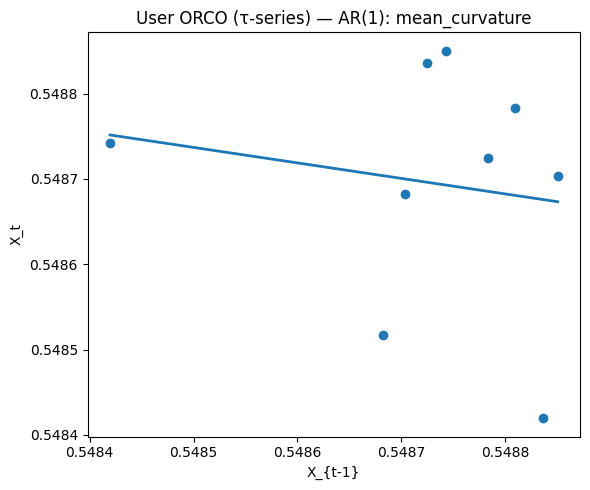

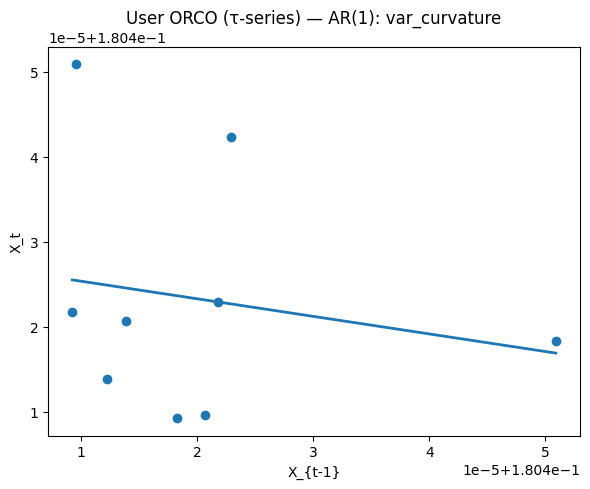

{
  "mean_curvature": {
    "c": 0.6484116817616723,
    "phi": -0.18172230147865776,
    "nobs": 9
  },
  "var_curvature": {
    "c": 0.21777345357952527,
    "phi": -0.20701790758675997,
    "nobs": 9
  }
}


In [17]:
# Fit AR(1) on τ-series and plot transitions
def fit_ar1_on_series(y):
    y = pd.Series(y).dropna().values
    X_tm1, X_t = y[:-1], y[1:]
    X = add_constant(X_tm1)
    return OLS(X_t, X).fit()

def plot_user_series_with_fit(name, series_vals):
    y = pd.Series(series_vals).dropna().values
    if len(y) < 2:
        return None
    X_tm1, X_t = y[:-1], y[1:]
    X = add_constant(X_tm1)
    mdl = OLS(X_t, X).fit()
    xgrid = np.linspace(min(X_tm1), max(X_tm1), 200)
    ygrid = mdl.params[0] + mdl.params[1] * xgrid
    plt.figure(figsize=(6,5))
    plt.scatter(X_tm1, X_t)
    plt.plot(xgrid, ygrid, linewidth=2)
    plt.title(f"User ORCO (τ-series) — AR(1): {name}")
    plt.xlabel("X_{t-1}")
    plt.ylabel("X_t")
    plt.tight_layout()
    plt.show()
    return mdl

results = {}

for col in ["mean_curvature","var_curvature"]:
    if user_tau_summary[col].notna().sum() >= 3:
        mdl = plot_user_series_with_fit(col, user_tau_summary[col].values)
        results[col] = {"c": float(mdl.params[0]), "phi": float(mdl.params[1]), "nobs": int(mdl.nobs)}


print(json.dumps(results, indent=2))
